In [15]:
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import dgl
import ssl
import os
import h5py
import networkx as nx
from graph_generation import GraphBuilding
from Vocabulary import Vocabulary
ssl._create_default_https_context = ssl._create_unverified_context # Use it to solve SSL 



## Basic Definition



In [2]:
image_path = "../../../../../../srv/scratch/bic/peter/Report-nmi-wsi/Images/test/118334_005.png"
target_path = "./target_img/target.png"
encoder_path = "../../../../../../srv/scratch/bic/peter/encoder/GSage_encoder_epoch20.pt"
decoder_path = "../../../../../../srv/scratch/bic/peter/decoder/GSage_decoder_epoch20.pt"

anno_path = "../../../../../../srv/scratch/bic/peter/Report-nmi-wsi/test_annotation.json"


In [3]:
!ls ../../../../../../srv/scratch/bic/peter

decoder			   full-graph		      Report-nmi-wsi
download_nmi_wsi_data.sh~  GNN-Histo-Caption
encoder			   PHOENIX-2014-T-release-v3


## Show Image

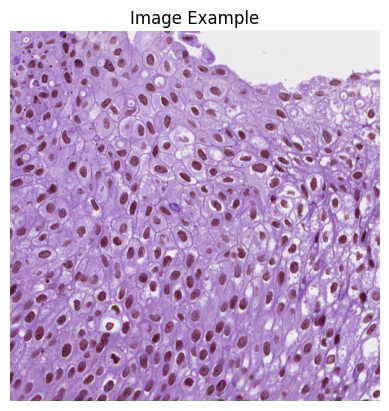

In [4]:
image = cv2.imread(image_path)
dir_name, img_name = os.path.split(image_path)
# Convert the BGR image to RGB (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image)
plt.title("Image Example")
plt.axis('off')  # Hide the axis
plt.show()

In [5]:
name = img_name.split(".")[0]
with open(anno_path, 'r') as json_file:
    data = json.load(json_file)
# print(data.keys())
all_captions = data[name]['caption']
for i in all_captions:
    print(i)

Nuclear features show mild pleomorphism. No nuclear crowding is seen. The urothelium shows some degree of loss of polarity. Mitotic figures are infrequent and limited to the lower half of the urothelium. The nucleoli are mostly inconspicuous. Low grade.
Mild pleomorphism and cytologic atypia is present. There are no signs of crowding in the nuclei. Polarity is partially lost. There are infrequent mitotic figures throughout the tissue. The nucleoli are mostly inconspicuous. Low grade.
Slight variability in nuclear size shape and outline, consistent with mild pleomorphism. The nuclei are normally crowded. The urothelium shows some degree of loss of polarity. There are infrequent mitotic figures throughout the tissue. Visible and prominent nucleoli are not observed or exceedingly rare. Low grade.
Mild pleomorphism is present. There is a normal degree of crowding. There is no full-thickness lack of polarity observed. Mitosis is infrequent throughout the tissue. The nuclei have inconspicuou

# Graph Generation and Visualisation


In [19]:

print(dir_name)
print(img_name)

folder = "inference_image"
GB = GraphBuilding(target_path)
GB.build_single(image_path,"graph")

../../../../../../srv/scratch/bic/peter/Report-nmi-wsi/Images/test
118334_005.png
File already downloaded.


UnpicklingError: invalid load key, '\x0a'.

### Cell Graph Visualisation

<class 'dgl.heterograph.DGLGraph'>
Graph(num_nodes=372, num_edges=2217,
      ndata_schemes={'feat': Scheme(shape=(514,), dtype=torch.float32), 'centroid': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})


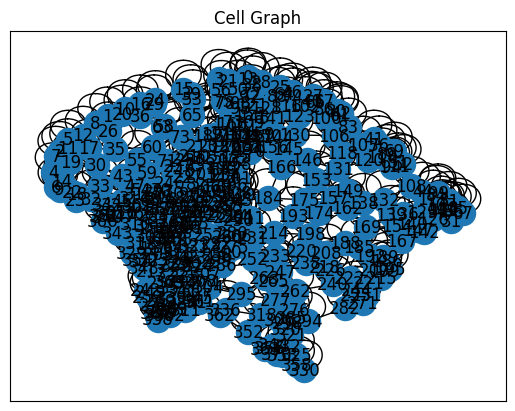

In [6]:
cg_path = "graph/cell_graphs/"
cg_path = os.path.join("graph/cell_graphs/","118334_005.bin")
tg_path = os.path.join("graph/tissue_graphs/","118334_005.bin")
cg = dgl.load_graphs(cg_path)[0][0]
tg = dgl.load_graphs(tg_path)[0][0]
print((type(cg)))
print(cg)
#cg_vis = dgl.to_networkx(cg)
nx_cg = cg.to_networkx().to_undirected()
# pos = nx.kamada_kawai_layout(nx_cg)
nx.draw_networkx(nx_cg)
plt.title("Cell Graph")
plt.show()

### Tissue Graph Visualisation

Graph(num_nodes=2, num_edges=4,
      ndata_schemes={'feat': Scheme(shape=(514,), dtype=torch.float32), 'centroid': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})


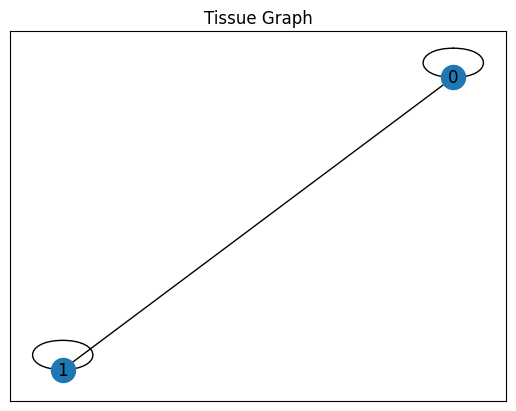

In [7]:
print(tg)
nx_tg = tg.to_networkx().to_undirected()
# pos = nx.kamada_kawai_layout(nx_cg)
nx.draw_networkx(nx_tg)
plt.title("Tissue Graph")
plt.show()

## Model Loading

In [13]:
# load assignment mat
def h5_to_tensor(h5_path):
    h5_object = h5py.File(h5_path, 'r')
    out = torch.from_numpy(np.array(h5_object['assignment_matrix']))
    return out.float().cuda()
assign_path = os.path.join("graph/assignment_mat/","118334_005.h5")
assign_mat = [h5_to_tensor(assign_path)]
print(cg)
print(tg)
# print(assign_mat.shape)

Graph(num_nodes=372, num_edges=2217,
      ndata_schemes={'feat': Scheme(shape=(514,), dtype=torch.float32), 'centroid': Scheme(shape=(2,), dtype=torch.float32), 'h': Scheme(shape=(514,), dtype=torch.float32), 'neigh': Scheme(shape=(514,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=2, num_edges=4,
      ndata_schemes={'feat': Scheme(shape=(514,), dtype=torch.float32), 'centroid': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})


In [14]:
encoder=  torch.load(encoder_path)
decoder=  torch.load(decoder_path)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cg.ndata['feat'] = torch.nan_to_num(cg.ndata['feat'], nan=0.0)
tg.ndata['feat'] = torch.nan_to_num(tg.ndata['feat'], nan=0.0)
cg = cg.to(DEVICE)
tg = tg.to(DEVICE)
out = encoder(cg,tg,assign_mat)
out = decoder.predict(out)
print(out)


torch.Size([1, 50])
tensor([[28, 29, 30,  2,  3,  1,  7,  4, 43, 85, 78, 11, 12,  1, 16,  4, 33, 60,
         21, 61, 14, 62, 41,  1, 22,  4, 23,  1, 14, 26,  8, 67, 25,  1, 92, 81,
          1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])


In [31]:
def embed2sentence(decode_output,vocab_file):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    for idx,embed in enumerate(decode_output):
        sentence = " ".join([vocab.idx2word[int(idx)] for idx in embed])

        sentence = sentence.replace("<pad>","")

        sentence = ' '.join(sentence.split()).replace("<end>", ".")
        # if j == 0:
        #     print("________________")
        #     # print(embed)
        sentences = sentence.split('. ')

        # Capitalize the first letter of each sentence and join them back together
        capitalized_text = '. '.join(sentence.capitalize() for sentence in sentences)

        #     print(f"______________")
        #     j = 1
    return capitalized_text


In [33]:
text = embed2sentence(out,'vocab_bladderreport.pkl')
print(text)

Nuclear features show mild pleomorphism . There is a moderate degree of crowding . Polarity is not completely lost toward the surface urothelium . Mitosis is rare . The nucleoli are mostly inconspicuous . Low grade .


In [34]:
print(all_captions[0])

Nuclear features show mild pleomorphism. No nuclear crowding is seen. The urothelium shows some degree of loss of polarity. Mitotic figures are infrequent and limited to the lower half of the urothelium. The nucleoli are mostly inconspicuous. Low grade.


In [35]:
print(all_captions[1])

Mild pleomorphism and cytologic atypia is present. There are no signs of crowding in the nuclei. Polarity is partially lost. There are infrequent mitotic figures throughout the tissue. The nucleoli are mostly inconspicuous. Low grade.


## Inference and Result Demonstration

   Column1  Column2  Column3  Column4  Column5  Column6  Column7
0        1        6       11       10       11        6       11
1        2        7       12        7        1        7       12
2        3        8       13        8       13        8        3
3        4        9       14       39       24       19       14
4        5       10       15       10       15       10       15


/home/z5313504/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/z5313504/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/z5313504/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/z5313504/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

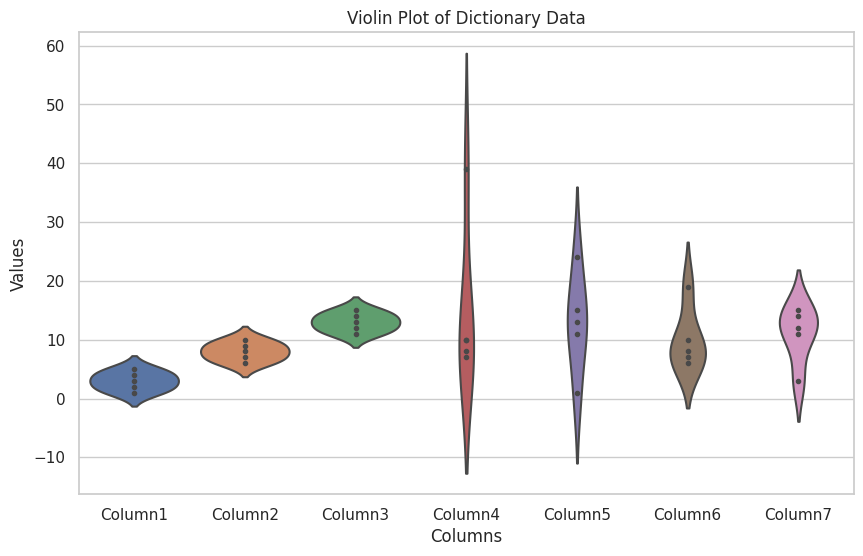

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
data_dict = {
    'Column1': [1, 2, 3, 4, 5],
    'Column2': [6, 7, 8, 9, 10],
    'Column3': [11, 12, 13, 14, 15],
    'Column4': [10, 7, 8, 39, 10],
    'Column5': [11, 1, 13, 24, 15],
    'Column6': [6, 7, 8, 19, 10],
    'Column7': [11, 12, 3, 14, 15]
}
df = pd.DataFrame(data_dict)
print(df)
sns.set(style="whitegrid")  # Optional: Set the plot style

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

# Create the violin plot
sns.violinplot(data=df, inner="points")

# Optional: Add labels and a title
plt.xlabel("Columns")
plt.ylabel("Values")
plt.title("Violin Plot of Dictionary Data")

# Show the plot
plt.show()